# Testing for Cointegration amongst German Stocks

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pandas_datareader import data
from datetime import datetime
from numpy.random import randn
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


## Import all DAX adjusted closing prices for the past 10 years

In [3]:
# Create a list of ticker symbols for DAX stocks
dax_tickers = ['1COV.DE', 'ADS.DE', 'ALV.DE', 'BAS.DE', 'BAYN.DE', 'BEI.DE', 'BMW.DE', 'CON.DE', 'DAI.DE', 
               'DB1.DE', 'DBK.DE', 'DPW.DE', 'DTE.DE', 'DWNI.DE', 'EOAN.DE', 'FME.DE', 'FRE.DE', 'HEI.DE', 
               'HEN3.DE', 'IFX.DE', 'LIN.DE', 'MRK.DE', 'MTX.DE', 'MUV2.DE', 'RWE.DE', 'SAP.DE', 'SIE.DE', 
               'VNA.DE', 'VOW3.DE', 'WDI.DE']

In [4]:
# Define start and end date
start = datetime(2010, 8, 10)
end = datetime(2020, 8, 12)

In [5]:
# Import the adjusted closing prices for these stocks from Yahoo Finance
dax_prices = data.DataReader(dax_tickers, data_source='yahoo', start=start, end=end)['Adj Close']

In [6]:
len(dax_prices)

2538

In [7]:
dax_prices.isna().any()

Symbols
1COV.DE     True
ADS.DE     False
ALV.DE     False
BAS.DE     False
BAYN.DE    False
BEI.DE     False
BMW.DE     False
CON.DE     False
DAI.DE     False
DB1.DE     False
DBK.DE     False
DPW.DE     False
DTE.DE     False
DWNI.DE     True
EOAN.DE    False
FME.DE     False
FRE.DE     False
HEI.DE     False
HEN3.DE    False
IFX.DE     False
LIN.DE     False
MRK.DE     False
MTX.DE     False
MUV2.DE    False
RWE.DE     False
SAP.DE     False
SIE.DE     False
VNA.DE      True
VOW3.DE    False
WDI.DE     False
dtype: bool

## Cointegration

In [224]:
# Define a function that tests for cointegration between any of the stocks in a DataFrame
def cointegration_finder(dataframe):
    cointegrated = []
    for tick1 in dataframe.columns:
        for tick2 in dataframe.columns:
            if tick1 != tick2:
                Y = np.array(dataframe[tick1])
                X = np.array(dataframe[tick2])
                model = sm.OLS(Y, X)
                result = model.fit()
                beta = result.params
                residuals = Y - beta * X
                cadf = ts.adfuller(residuals)
                p_val = cadf[1]
                if p_val <= 0.05:
                    coin = (tick1, tick2, p_val)
                    cointegrated.append(coin)
    return cointegrated

In [228]:
dax_reduced = dax_prices.drop(columns=['1COV.DE', 'VNA.DE'])

In [229]:
dax_coints = cointegration_finder(dax_reduced)

In [236]:
def third(elem):
    return elem[2]

In [239]:
dax_coints.sort(key=third)
dax_coints

[('HEI.DE', 'HEN3.DE', 0.0014442770370510399),
 ('HEN3.DE', 'HEI.DE', 0.0015740283736898678),
 ('IFX.DE', 'DWNI.DE', 0.002904810535933389),
 ('MTX.DE', 'DB1.DE', 0.0037850537506293677),
 ('DWNI.DE', 'IFX.DE', 0.0038285843434317),
 ('DB1.DE', 'MTX.DE', 0.0044902067791316325),
 ('BMW.DE', 'BAS.DE', 0.011248353200713246),
 ('BAS.DE', 'BMW.DE', 0.011462492087435942),
 ('VOW3.DE', 'EOAN.DE', 0.018838208203225633),
 ('DAI.DE', 'BAYN.DE', 0.01995924885620037),
 ('MTX.DE', 'DWNI.DE', 0.020003115984282838),
 ('EOAN.DE', 'VOW3.DE', 0.02010254170971957),
 ('BAYN.DE', 'DAI.DE', 0.021584006869167567),
 ('SAP.DE', 'MTX.DE', 0.025294425174870374),
 ('DTE.DE', 'MRK.DE', 0.02868591911394122),
 ('DWNI.DE', 'MTX.DE', 0.0286967605405921),
 ('MTX.DE', 'SAP.DE', 0.030795362989416514),
 ('MRK.DE', 'DTE.DE', 0.03104627201122779),
 ('ALV.DE', 'MTX.DE', 0.04463371895782262),
 ('MTX.DE', 'ADS.DE', 0.0458464349828878),
 ('VOW3.DE', 'RWE.DE', 0.04844257378410985),
 ('HEI.DE', 'FRE.DE', 0.04879696172001125),
 ('MTX

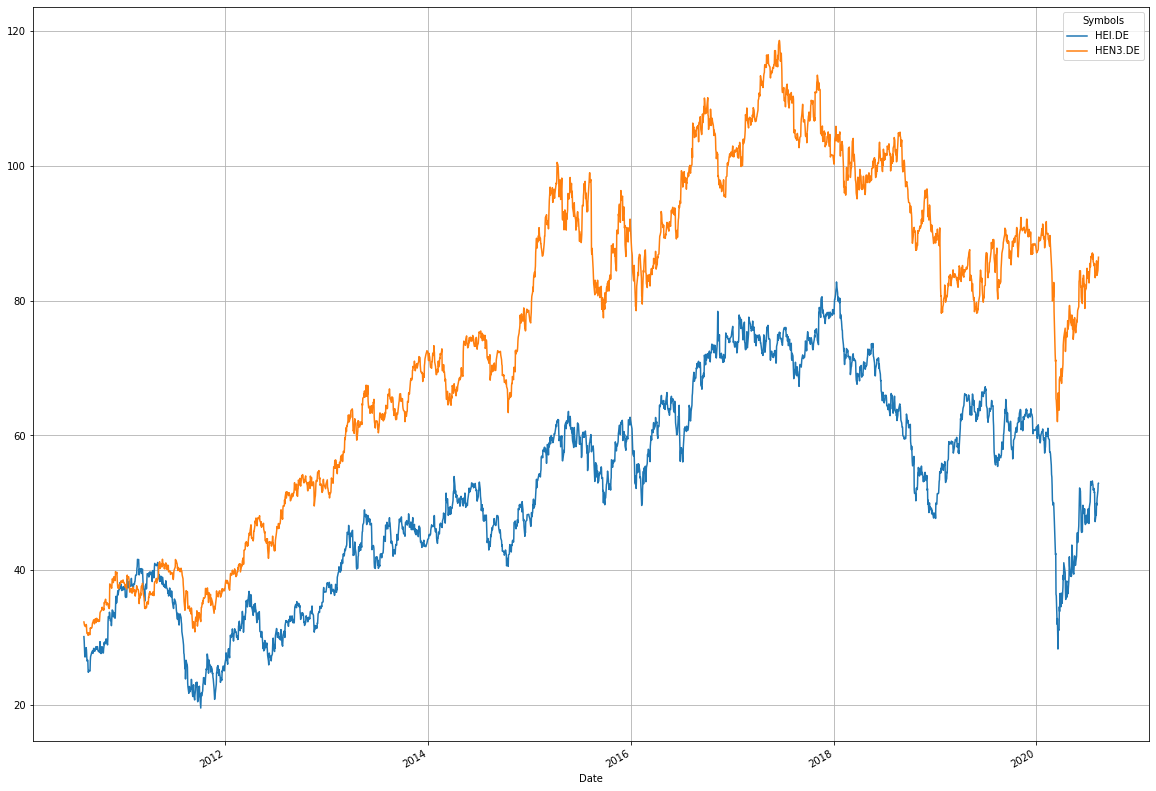

In [8]:
dax_prices[['HEI.DE', 'HEN3.DE']].plot(grid=True, figsize=(20,15))

In [9]:
# Get residuals for HEI and HEN
HEI = np.array(dax_prices['HEI.DE'])
HEN3 = np.array(dax_prices['HEN3.DE'])
model = sm.OLS(HEI, HEN3)
result = model.fit()
beta = result.params
residuals = HEI - beta * HEN3

In [10]:
hei_hen = pd.DataFrame()
hei_hen['HEI.DE'] = HEI
hei_hen['HEN3.DE'] = HEN3
hei_hen['Residuals'] = residuals
hei_hen.index = dax_prices.index

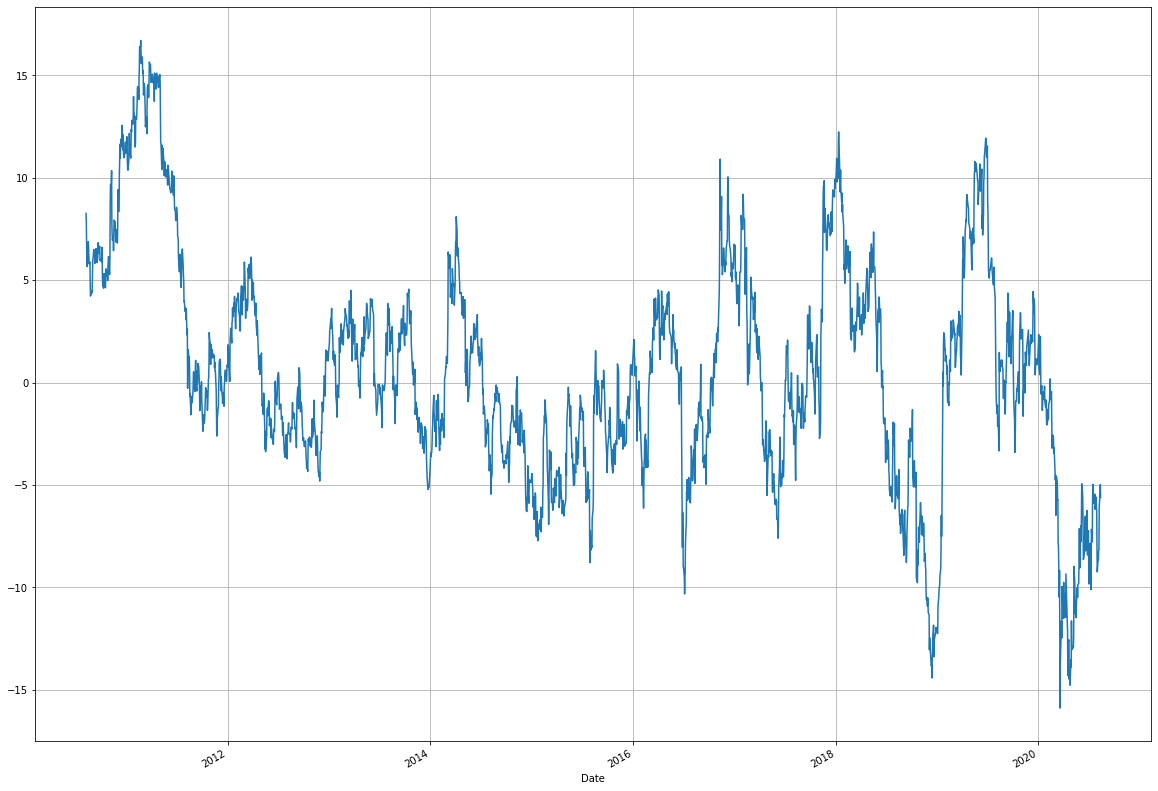

In [11]:
hei_hen['Residuals'].plot(grid=True, figsize=(20,15))

In [12]:
x_range = range(int(dax_prices['HEN3.DE'].min()), int(dax_prices['HEN3.DE'].max()))
y_range = beta * x_range

Text(0, 0.5, 'HEI.DE')

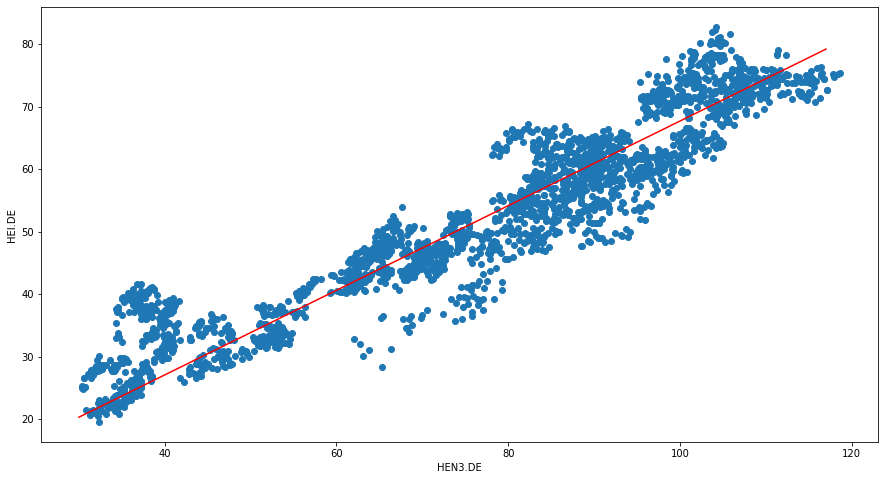

In [13]:
plt.figure(figsize=(15,8))
plt.scatter(dax_prices['HEN3.DE'], dax_prices['HEI.DE'])
plt.plot(x_range, y_range, c = 'r')
plt.xlabel('HEN3.DE')
plt.ylabel('HEI.DE')

In [14]:
mean = hei_hen['Residuals'].mean()
mean

0.5750522302432547

In [15]:
std = hei_hen['Residuals'].std()
std

5.44649958289074

In [16]:
hei_hen['HEI_ret'] = np.log(hei_hen['HEI.DE'] / hei_hen['HEI.DE'].shift(1))
hei_hen['HEN3_ret'] = np.log(hei_hen['HEN3.DE'] / hei_hen['HEN3.DE'].shift(1))

In [17]:
hei_hen.head()

,HEI.DE,HEN3.DE,Residuals,HEI_ret,HEN3_ret
Date,,,,,
2010-08-09,30.135191,32.313820,8.266255,NaN,NaN
2010-08-10,29.458931,32.054886,7.765233,-0.022697,-0.008045
2010-08-11,28.236919,31.828831,6.696208,-0.042367,-0.007077
2010-08-12,27.366869,31.730185,5.892918,-0.031297,-0.003104
2010-08-13,27.101904,31.672655,5.666887,-0.009729,-0.001815


In [18]:
hei_hen['250d'] = hei_hen['Residuals'].rolling(250).std()
hei_hen['-250d'] = hei_hen['250d'] * -1.0

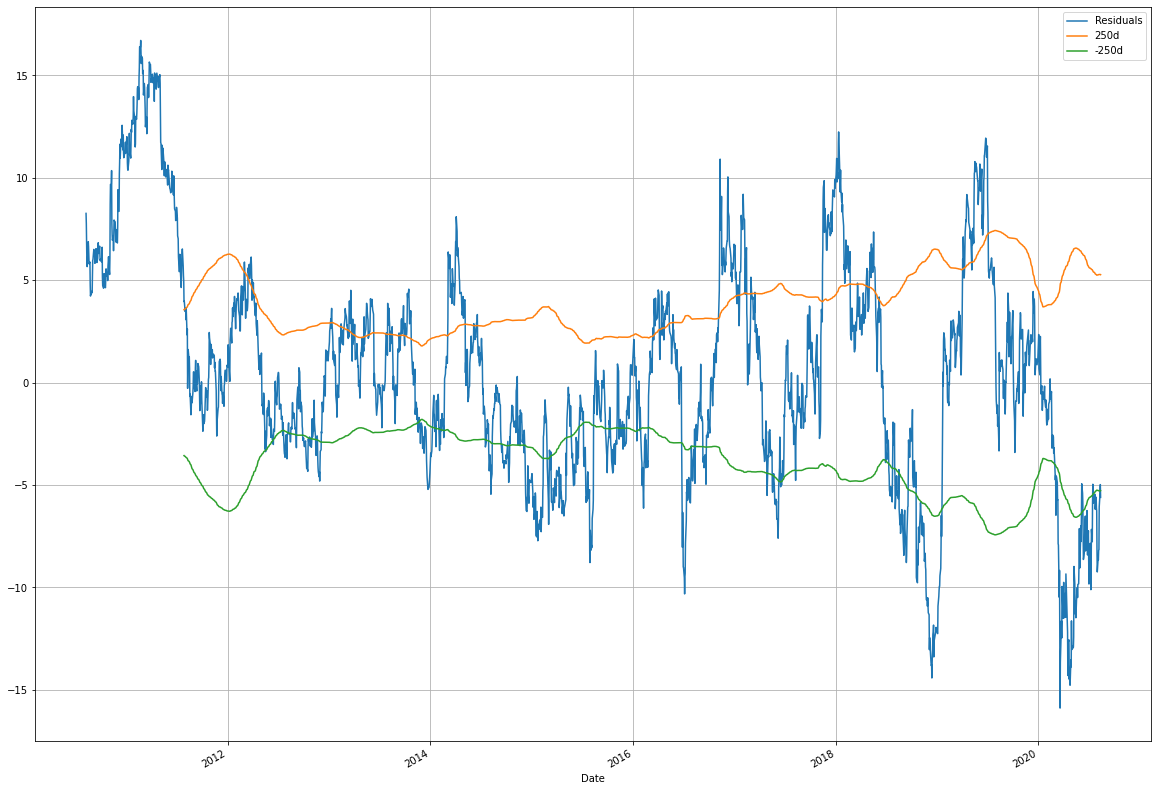

In [19]:
hei_hen[['Residuals', '250d', '-250d']].plot(grid=True, figsize=(20,15))

# Building a Strategy

Knowing that the stocks from the above analysis were cointegrated over the past 10 years is nice but it doesn't mean that we could've built a profitable trading strategy based on that knowledge. In order to do that we need to first develop a strategy that we could backtest over time. 

Here are some initial thoughts: check cointegration at multiple regular intervals and use the resulting beta as the hedge ratio until the next CADF is done and a slightly different beta arises. But how do we know how far to look back when testing for cointegration? After all, we need to make sure to have enough data points to have a statistically significant result from the CADf that is reliable but also want to be able to have a fairly "up-to-date" hedge ratio that closely models the recent relationship between the two stocks. Let's try a window of two years for the CADFs.

But then the next question is: What are our trading signals? When do we go short one stock and long the other? Here, we could use an indicator such as the moving average standard deviation of the residuals over the past two years. If the residual, which is compute don the most recent hedging ratio, is more than a (moving average) standard deviation from the mean (0), a position is entered into. 

Let's see what that would look like for Heidelberg Cement and Henkel.

## Creating sub-dataframes

As a first step, we can split the data into 10 DataFrames, one for each year of stock data, and use these for our underlying analysis. Once we have the first two years we can build the subsequent years including trading signals based on the earlier DataFrames. Let's see how we can split the data equally.

In [20]:
# Find modulus of the length of the DataFrame divided by 10
split_len = int((len(hei_hen) - (len(hei_hen) % 10)) / 10)
split_len

253

In [21]:
hei_hen.head()

,HEI.DE,HEN3.DE,Residuals,HEI_ret,HEN3_ret,250d,-250d
Date,,,,,,,
2010-08-09,30.135191,32.313820,8.266255,NaN,NaN,NaN,NaN
2010-08-10,29.458931,32.054886,7.765233,-0.022697,-0.008045,NaN,NaN
2010-08-11,28.236919,31.828831,6.696208,-0.042367,-0.007077,NaN,NaN
2010-08-12,27.366869,31.730185,5.892918,-0.031297,-0.003104,NaN,NaN
2010-08-13,27.101904,31.672655,5.666887,-0.009729,-0.001815,NaN,NaN


In [22]:
# Create first DataFrame
hh_1 = hei_hen.iloc[:split_len, :2]
hh_1

,HEI.DE,HEN3.DE
Date,,
2010-08-09,30.135191,32.313820
2010-08-10,29.458931,32.054886
2010-08-11,28.236919,31.828831
2010-08-12,27.366869,31.730185
2010-08-13,27.101904,31.672655
...,...,...
2011-07-27,31.998762,39.955269
2011-07-28,30.869867,39.758907
2011-07-29,30.567762,39.290955


In [23]:
df_list = ['hei_hen_' + str(i) for i in range(1, 11)]
df_list

['hei_hen_1',
 'hei_hen_2',
 'hei_hen_3',
 'hei_hen_4',
 'hei_hen_5',
 'hei_hen_6',
 'hei_hen_7',
 'hei_hen_8',
 'hei_hen_9',
 'hei_hen_10']

In [24]:
# Create the 10 equally long DataFrames
for i, df in enumerate(df_list):
    vars()[df] = hei_hen.iloc[split_len * i:split_len * (i+1), :2]

## Test for 2 year cointegration

In [25]:
hh_23 = pd.concat([hei_hen_2, hei_hen_3])

In [26]:
def test_cointegration(df):
    y = np.array(df[df.columns[0]])
    x = np.array(df[df.columns[1]])
    model = sm.OLS(y, x)
    result = model.fit()
    beta = result.params
    residuals = y - beta * x
    cadf = ts.adfuller(residuals)
    p_val = cadf[1]
    
    return beta, residuals, p_val

In [33]:
hh23_beta, hh23_residuals, hh23_pval = test_cointegration(hh_23)

In [34]:
hh23_pval

0.01864084911686869

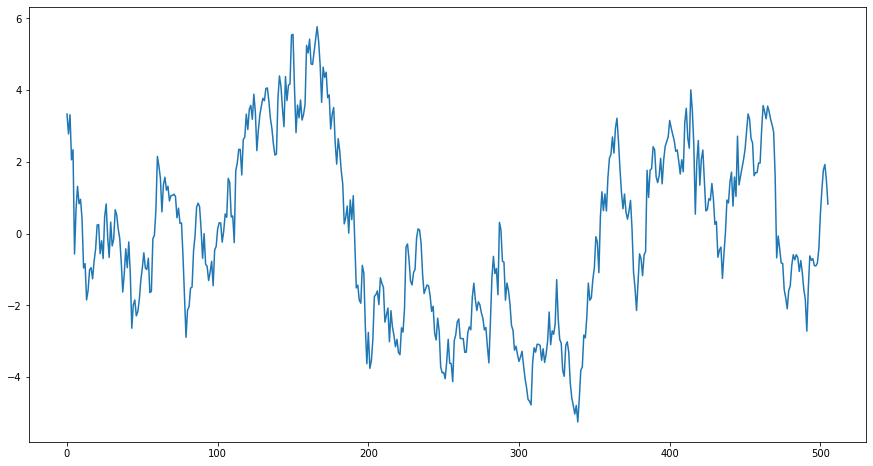

In [42]:
plt.figure(figsize=(15,8))
plt.plot(hh23_residuals)

## Come up with trading signals

As a starting point let's have a look at teh standard deviation of the residuals and whether we could use it to create a signal. Let's have a look at what the standard deviation of the resiudals was in our time frame.

In [44]:
hh23_std = hh23_residuals.std()
hh23_std

2.403659240565668

In [49]:
# Create list of values for +std and -std
hh23_std_pos = [hh23_std] * len(hh23_residuals)
hh23_std_neg = [hh23_std * -1] * len(hh23_residuals)

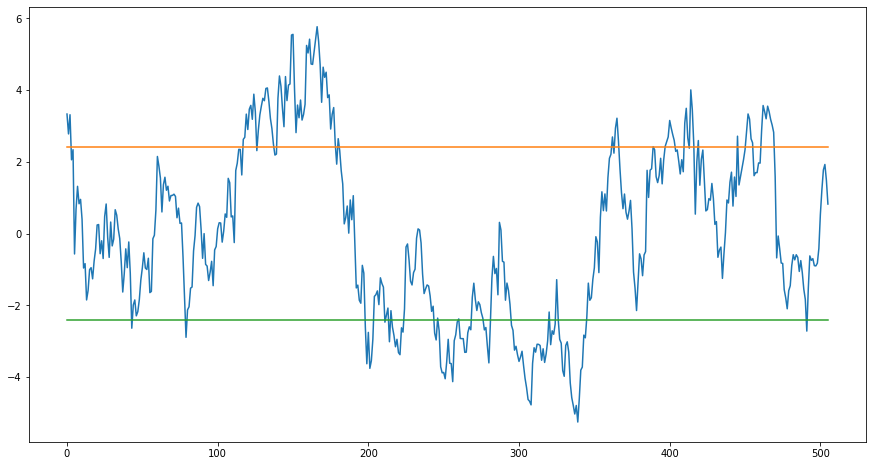

In [50]:
# Plot the standard deviation boundaries
plt.figure(figsize=(15,8))
plt.plot(hh23_residuals)
plt.plot(hh23_std_pos)
plt.plot(hh23_std_neg)

This almost doesn't seem sufficient enough, meaning we won't be making enough trades and we might want to take into account more extreme movements as well. For example, we could make +2 and -2 standard trading signals and +4 and -4 strong signals, where double the money gets invested for example. Let's plot that.

In [51]:
# Create new boundaries
hh23_pos_sig = [2.0] * len(hh23_residuals)
hh23_pos2_sig = [4.0] * len(hh23_residuals)
hh23_neg_sig = [-2.0] * len(hh23_residuals)
hh23_neg2_sig = [-4.0] * len(hh23_residuals)

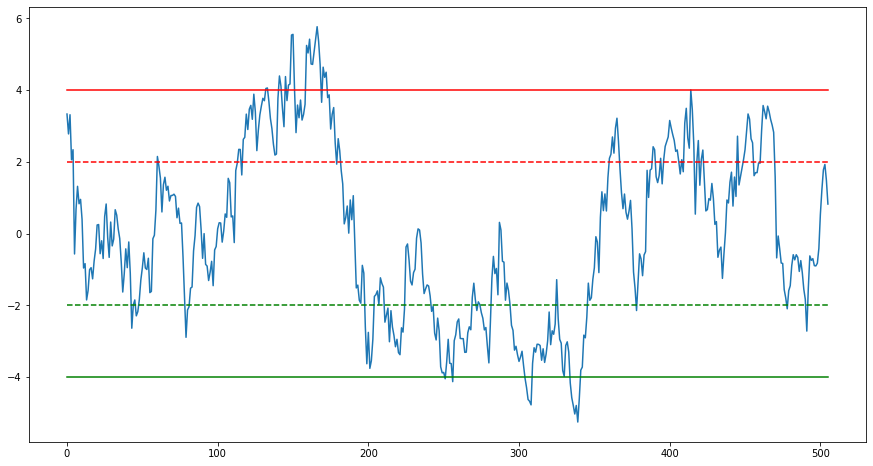

In [54]:
# Plot the new boundaries
plt.figure(figsize=(15,8))
plt.plot(hh23_residuals)
plt.plot(hh23_pos_sig, '--', c='r')
plt.plot(hh23_pos2_sig, c='r')
plt.plot(hh23_neg_sig, '--', c='g')
plt.plot(hh23_neg2_sig, c='g')

Based on the above a trading rule could be that the standard signals lead to a standard investment in one directiona and the strong signals lead to double the standard investment in that same direction. A position is only liquidated and the opposite direction is assumed once a boundary on the other side of the zero mark has been reached, in order to lock in good returns.

## Create trading signals

The stock prices of Heidelberg Cement and Henkel have been shown to have bene cointegrated in year 2 and 3. Based on this knowledge and the boundaries that we came up with above, let's construct some signals for year 4 and see what teh resulst look like.

In [65]:
hh23_beta

array([0.68490437])

In [87]:
# Add a column with percentage change for HEI and HEN3
hei_hen_4['HEI.DE_pct_ch'] = hei_hen_4['HEI.DE'].pct_change()
hei_hen_4['HEN3.DE_pct_ch'] = hei_hen_4['HEN3.DE'].pct_change()

In [88]:
# Add residuals to year 4 DataFrame
hei_hen_4['Residuals'] = hei_hen_4['HEI.DE'] - hh23_beta * hei_hen_4['HEN3.DE']

In [89]:
hei_hen_4.head()

,HEI.DE,HEN3.DE,Residuals,Signals,HEI.DE_pct_ch,HEN3.DE_pct_ch
Date,,,,,,
2013-07-31,46.682621,63.255154,3.358890,1.0,NaN,NaN
2013-08-01,46.601765,64.466324,2.448498,0.0,-0.001732,0.019147
2013-08-02,46.108582,63.985298,2.284771,0.0,-0.010583,-0.007462
2013-08-05,47.103031,64.234413,3.108601,0.0,0.021568,0.003893
2013-08-06,46.334961,63.968117,2.522918,0.0,-0.016306,-0.004146


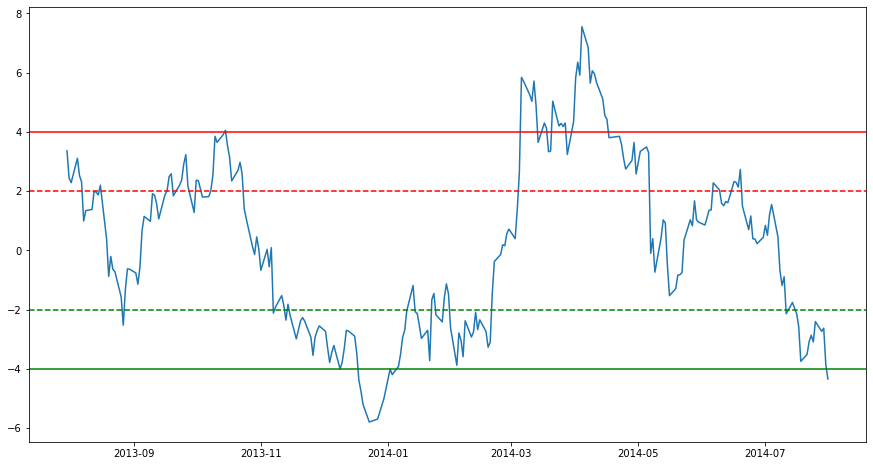

In [90]:
# Plot the new boundaries
plt.figure(figsize=(15,8))
plt.plot(hei_hen_4['Residuals'])
plt.axhline(2.0, ls='--', c='r')
plt.axhline(4.0, c='r')
plt.axhline(-2.0, ls='--', c='g')
plt.axhline(-4.0, c='g')

Before we can create signals based on the resiudals, we need to understand the logic behind te pairs trading that follows. The residuals are calculated as follows:

Residual = HEI.DE - hh23_beta * HEN3.DE

This means that the residual is positive if either HEI.DE is "too" high, HEN3.DE is "too" low or both. Too low or too high here refers to their levels being higher than predicted by the model. Because we expect them to revert back to the mean, i.e. the zero line, we can enter a position in each of the stocks that bets on that mean-reversion happening. 

In the case where the residual is positive we would therefore go short 1 unit of HEI.DE and short 0.685 units of HEN3.DE (units here refer to shares).

Let's implement that.

In [91]:
hh4_resds = np.array(hei_hen_4['Residuals'])

In [92]:
hh4_sigs = np.zeros(hh4_resds.shape)

In [93]:
for i in range(len(hh4_resds)):
    if i == 0:
        if hh4_resds[i] > 4:
            hh4_sigs[i] = 2
        elif hh4_resds[i] > 2:
            hh4_sigs[i] = 1
        elif hh4_resds[i] < -4:
            hh4_sigs[i] = -2
        elif hh4_resds[i] < -2:
            hh4_sigs[i] = -1
        else:
            hh4_sigs[i] = 0
    elif (hh4_resds[i-1] <= 2) & (hh4_resds[i]> 2):
        hh4_sigs[i] = 1
    elif (hh4_resds[i-1] <= 4) & (hh4_resds[i]> 4):
        hh4_sigs[i] = 2
    elif (hh4_resds[i-1] >= -2) & (hh4_resds[i]< -2):
        hh4_sigs[i] = -1
    elif (hh4_resds[i-1] >= -4) & (hh4_resds[i]< -4):
        hh4_sigs[i] = -2
    else:
        hh4_sigs[i] = 0

In [94]:
hei_hen_4['Signals'] = hh4_sigs

In [95]:
hei_hen_4.head(30)

,HEI.DE,HEN3.DE,Residuals,Signals,HEI.DE_pct_ch,HEN3.DE_pct_ch
Date,,,,,,
2013-07-31,46.682621,63.255154,3.358890,1.0,NaN,NaN
2013-08-01,46.601765,64.466324,2.448498,0.0,-0.001732,0.019147
2013-08-02,46.108582,63.985298,2.284771,0.0,-0.010583,-0.007462
2013-08-05,47.103031,64.234413,3.108601,0.0,0.021568,0.003893
2013-08-06,46.334961,63.968117,2.522918,0.0,-0.016306,-0.004146
2013-08-07,46.173271,64.045418,2.308284,0.0,-0.003490,0.001208
2013-08-08,46.132839,65.909409,0.991197,0.0,-0.000876,0.029104
2013-08-09,46.617943,66.106972,1.340989,0.0,0.010515,0.002997
2013-08-12,46.504749,65.883629,1.380764,0.0,-0.002428,-0.003379


## Attach monetary values to investments

In this example I will simply use USD 1,000 as the standard investment. This means that if a trading signal of absolute magnitude 1 is reached, USD 1,000 is invested in either a long or short position. If a trading signal of absolute magnitude 2 is reached, USD 2,000 is invested in either a long or short position. The long position in our case represents the linear relationship we are relying on for mean reversion, which is HEI - 0.685*HEN3. Therefore, our "long position" is naturally long HEI and short HEN3. This position will be entered when the trading signal is negative because a negative signal occurs when the current values of these stocks is below its mean and should revert back up. The "short" position, meaning the position that is short HEI and long HEN3, is entered when we have a positive signal. Because a positive signal occurs when the linear combination of the prices of the two assets is above its mean and because we are expecting it to go back down (i.e. mean-revert), we have to go short teh combination. 

Before we get into the positions, let's see how the investment of USD 1,000 per standard investment would have to be split between the two assets.

In [102]:
# Set standard investment size at $1,000
investment_size = 1000.0

# Attach weights to HEI and HEN3
hei_weight = 1
hen_weight = hh23_beta

# Calculate the percenatge allocation to HEI and HEN3
hei_percent = hei_weight / (hei_weight + hen_weight)
hen_percent = hen_weight / (hei_weight + hen_weight)

# Compute the monetary investment size in each position
hei_investment = investment_size * hei_percent * -1
hen_investment = investment_size * hen_percent

In [103]:
hei_investment, hen_investment

(array([-593.50549283]), array([406.49450717]))

In [98]:
# Create an column for drawdowns
hei_hen_4['Drawdowns'] = hei_hen_4['Signals'].apply(lambda x: abs(x) * investment_size)

In [99]:
# Create an array for cashouts
hh4_cashout = np.zeros(hh4_resds.shape)

The cashout array will be filled when a long or short position is reversed. At reversal, the proceeds from the previous strategy are realised and the new (opposite direction) position is assumed. Cashout and drawdown therefore happen on the same day. Technically, if the strategy is indeed profitable, the strategy should be self-financing and delivering profits at somewhat regular intervals.

In [100]:
# Create array for HEI.DE and HEN3.DE positions
hei_pos = np.zeros(hh4_resds.shape)
hen_pos = np.zeros(hh4_resds.shape)

# Get the HEI.DE and HEN3.DE prices as an array as well
hei_price = np.array(hei_hen_4['HEI.DE'])
hen_price = np.array(hei_hen_4['HEN3.DE'])

In [105]:
for i in range(len(hh4_sigs)):
    if i == 0:
        if hh4_sigs[i] != 0:
            hei_pos[i]  = (hei_investment * hh4_sigs[i]) / hei_price[i]
            hen_pos[i]  = (hen_investment * hh4_sigs[i]) / hen_price[i]
    else:
        if hh4_sigs[i] == 0:
            hei_pos[i] = hei_pos[i-1]
            hen_pos[i] = hen_pos[i-1]
        elif hh4_sigs[i] == 2:
            hei_pos[i]  += (hei_investment * hh4_sigs[i]) / hei_price[i]
            hen_pos[i]  += (hen_investment * hh4_sigs[i]) / hen_price[i]
        elif hh4_sigs[i] == 1:
            if hei_pos[i-1] > 0:
                hh4_cashout[i] = (hei_pos[i-1] * -1 * hei_price[i]) + (hen_pos[i-1] * -1 * hen_price[i])
                hei_pos[i]  = (hei_investment * hh4_sigs[i]) / hei_price[i]
                hen_pos[i]  = (hen_investment * hh4_sigs[i]) / hen_price[i]
            else:
                hei_pos[i]  += (hei_investment * hh4_sigs[i]) / hei_price[i]
                hen_pos[i]  += (hen_investment * hh4_sigs[i]) / hen_price[i]
        elif hh4_sigs[i] == -2:
            hei_pos[i]  += (hei_investment * hh4_sigs[i]) / hei_price[i]
            hen_pos[i]  += (hen_investment * hh4_sigs[i]) / hen_price[i]
        elif hh4_sigs[i] == -1:
            if hei_pos[i-1] < 0:
                hh4_cashout[i] = (hei_pos[i-1] * -1 * hei_price[i]) + (hen_pos[i-1] * -1 * hen_price[i])
                hei_pos[i]  = (hei_investment * hh4_sigs[i]) / hei_price[i]
                hen_pos[i]  = (hen_investment * hh4_sigs[i]) / hen_price[i]
            else:
                hei_pos[i]  += (hei_investment * hh4_sigs[i]) / hei_price[i]
                hen_pos[i]  += (hen_investment * hh4_sigs[i]) / hen_price[i]

In [106]:
hei_hen_4['Cashout'] = hh4_cashout
hei_hen_4['HEI.DE_pos'] = hei_pos
hei_hen_4['HEN3.DE_pos'] = hen_pos

In [109]:
total_cashout = hei_hen_4['Cashout'].sum()
total_drawdown = hei_hen_4['Drawdowns'].sum()
total_cashout, total_drawdown

(277.00329214395975, 34000.0)

In [107]:
hei_hen_4.head(30)

,HEI.DE,HEN3.DE,Residuals,Signals,HEI.DE_pct_ch,HEN3.DE_pct_ch,Drawdowns,Cashout,HEI.DE_pos,HEN3.DE_pos
Date,,,,,,,,,,
2013-07-31,46.682621,63.255154,3.358890,1.0,NaN,NaN,1000.0,0.000000,-12.713628,6.426267
2013-08-01,46.601765,64.466324,2.448498,0.0,-0.001732,0.019147,0.0,0.000000,-12.713628,6.426267
2013-08-02,46.108582,63.985298,2.284771,0.0,-0.010583,-0.007462,0.0,0.000000,-12.713628,6.426267
2013-08-05,47.103031,64.234413,3.108601,0.0,0.021568,0.003893,0.0,0.000000,-12.713628,6.426267
2013-08-06,46.334961,63.968117,2.522918,0.0,-0.016306,-0.004146,0.0,0.000000,-12.713628,6.426267
2013-08-07,46.173271,64.045418,2.308284,0.0,-0.003490,0.001208,0.0,0.000000,-12.713628,6.426267
2013-08-08,46.132839,65.909409,0.991197,0.0,-0.000876,0.029104,0.0,0.000000,-12.713628,6.426267
2013-08-09,46.617943,66.106972,1.340989,0.0,0.010515,0.002997,0.0,0.000000,-12.713628,6.426267
2013-08-12,46.504749,65.883629,1.380764,0.0,-0.002428,-0.003379,0.0,0.000000,-12.713628,6.426267


We need to take into account that when we sell stock short, we have money coming in now and we will have to buy back the stock at a later date. The idea is that the proceeds from capital gains exceed those of the costs to finance the strategies.